# Synthetic data testing

## Setup

In [14]:
%matplotlib widget
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy

In [21]:
x = np.linspace(-2*np.pi, 2*np.pi, 500)

In [22]:
yy, xx = np.mgrid[-2*np.pi:2*np.pi:500j, -2*np.pi:2*np.pi:500j]

In [23]:
theta = np.pi/3
scale = 3
z = np.cos((-xx * np.sin(theta) + yy * np.cos(theta))*scale)

In [24]:
mpl.rc('text', usetex = True)

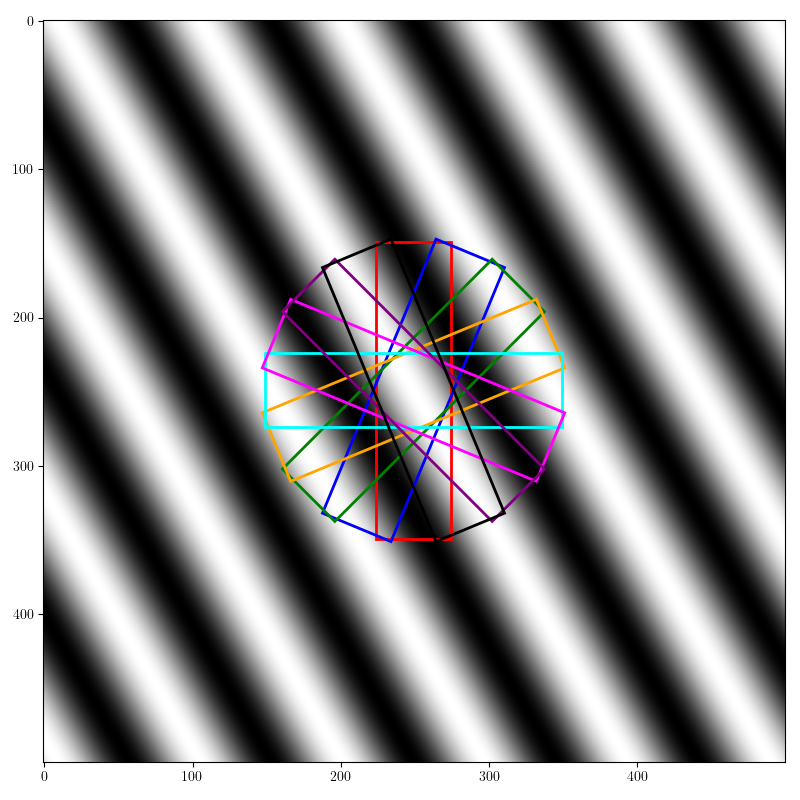

In [100]:
F, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(z, cmap='gray')
# plt.xticks([0, 124, 249, 374, 499], ['$-2\pi$', '$-\pi$', 0, '$\pi$', '$2\pi$'])
# plt.yticks([0, 124, 249, 374, 499], ['$-2\pi$', '$-\pi$', 0, '$\pi$', '$2\pi$'])
angles = np.linspace(-np.pi/2, np.pi/2, 9)[:-1]
colors = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta', 'purple', 'black', 'gray']
for i, angle in enumerate(angles):
    ax.add_patch(sample_box_disp((249, 249), angle, color=colors[i]))
F.tight_layout()

In [54]:
# sample_line: takes in a center point and an angle and returns evenly spaced coordinates along a line of the given length and angle. 
# The values start on the left for angles in the (-pi/2, pi/2) range.
# Note that for images shown with the origin at the top, angles increase clockwise
# At sample_ratio = 1 and angle a multiple of pi/2, this will pull actual pixels with no interpolation.
# Returns a tuple (x_coords, y_coords) of coordinate lists.
def sample_line(center_pt, angle, length=200, sample_ratio=1):
    start = np.subtract(center_pt, (length/2 * np.cos(angle), length/2 * np.sin(angle)))
    end = np.add(center_pt, (length/2 * np.cos(angle), length/2 * np.sin(angle)))
    return np.linspace(start[0], end[0], sample_ratio*length + 1), np.linspace(start[1], end[1], sample_ratio*length + 1)

In [91]:
### sample_box_disp:
# args:
#    center_pt: center of the box
#    angle: angle of the line samples, in standard unit circle orientation
#    width: how wide the box is
#    sample_length: how long the box is
#    color: what color the box is
# returns:
#    box: a matplotlib patch that can be applied to an image
def sample_box_disp(center_pt, angle, width=50, sample_length=200, color='red'):
    offset_vec = np.add((-sample_length/2*np.cos(angle), -sample_length/2*np.sin(angle)), (-width/2*np.cos(angle + np.pi/2), -width/2*np.sin(angle + np.pi/2)))
    corner = np.add(center_pt, offset_vec)
    box = mpl.patches.Rectangle(corner, width=sample_length, height=width, angle=np.degrees(angle), rotation_point='xy', fill=False, ec=color, lw=2)
    return box

In [78]:
# parallel_line_vals:
# args:
#    center_pt: center of the entire sample
#    angle: angle of the parallel sample lines
#    width: how wide the batch of parallel lines should be
#    sample_length: how many pixels long the sample lines should be
#    sample_ratio: how densely each sample line should be sampled
#    crop: whether to crop the image down to increase the speed of map_coordinates
# If crop is set, crops the image down to just the size needed for the lines (plus 20 pixels on each side for map_coordinate's interplation) to speed up computation significantly; the speed of map_coordinates seems to be sensitive to input size
# First finds a line of length given by width through the center point perpendicular to the parallel lines and computes center points (center_x, center_y) for the parallel lines
# The interpolated values from the ith line are stored in the ith row of the line_vals matrix
def parallel_line_vals(img, center_pt, angle, width=50, sample_length=200, sample_ratio=1, crop=True, pro_bar=True):
    if crop:
        radius = int(np.ceil(max(width/2, sample_length/2))) + 20
        start, end = (np.subtract(center_pt, radius), np.add(center_pt, radius))
        _img = img[start[1]:end[1], start[0]:end[0]]
        _center = np.subtract(center_pt, start)
    else:
        _img = img
        _center = center_pt
    center_x, center_y = sample_line(_center, angle + np.pi/2, width, 1)
    line_vals = np.empty((width + 1, sample_length*sample_ratio + 1))
    for i in tqdm(range(width + 1), disable=not pro_bar):
        line_x, line_y = sample_line((center_x[i], center_y[i]), angle, sample_length, sample_ratio)
        line_vals[i, :] = scipy.ndimage.map_coordinates(_img, np.vstack((line_y, line_x)))
    return line_vals

In [79]:
A = parallel_line_vals(z, (249, 249), 0, sample_ratio=1)

  0%|          | 0/51 [00:00<?, ?it/s]

In [62]:
A_raw = z[224:275, 149:350]

In [66]:
(A - A_raw).max()

5.551115123125783e-16

In [42]:
A.shape

(51, 201)

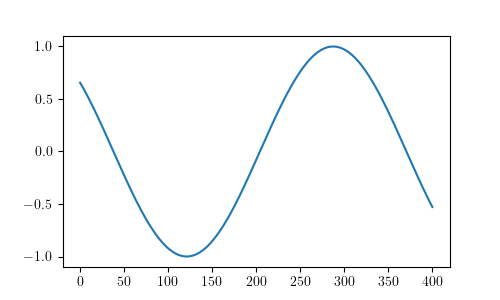

In [58]:
F, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(A[0, :])

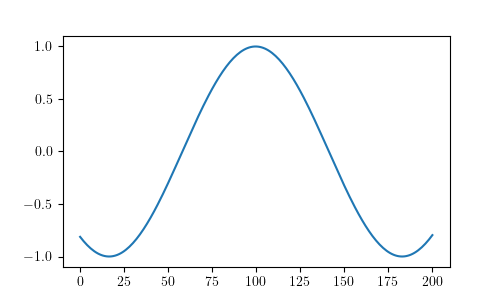

In [50]:
F, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(A[25, :])

In [101]:
def TAPE_raw(img, center_pt, num_angles=8, width=50, sample_length=200, sample_ratio=1, crop=True):
    if crop:
        radius = int(np.ceil(max(width/2, sample_length/2))) + 20
        start, end = (np.subtract(center_pt, radius), np.add(center_pt, radius))
        _img = img[start[1]:end[1], start[0]:end[0]]
        _center = np.subtract(center_pt, start)
    else:
        _img = img
        _center = center_pt
    raw_samples = np.empty((width + 1, sample_length + 1, num_angles))
    angles = np.linspace(-np.pi/2, np.pi/2, num_angles + 1)[:-1]
    for i, angle in enumerate(tqdm(angles)):
        raw_samples[:, :, i] = parallel_line_vals(
            _img,
            _center,
            angle,
            width=width,
            sample_length=sample_length,
            sample_ratio=sample_ratio,
            crop=False,
            pro_bar=False
        )
    return raw_samples

In [102]:
raw_tape = TAPE_raw(z, (249, 249))

  0%|          | 0/8 [00:00<?, ?it/s]

In [103]:
raw_tape.shape

(51, 201, 8)

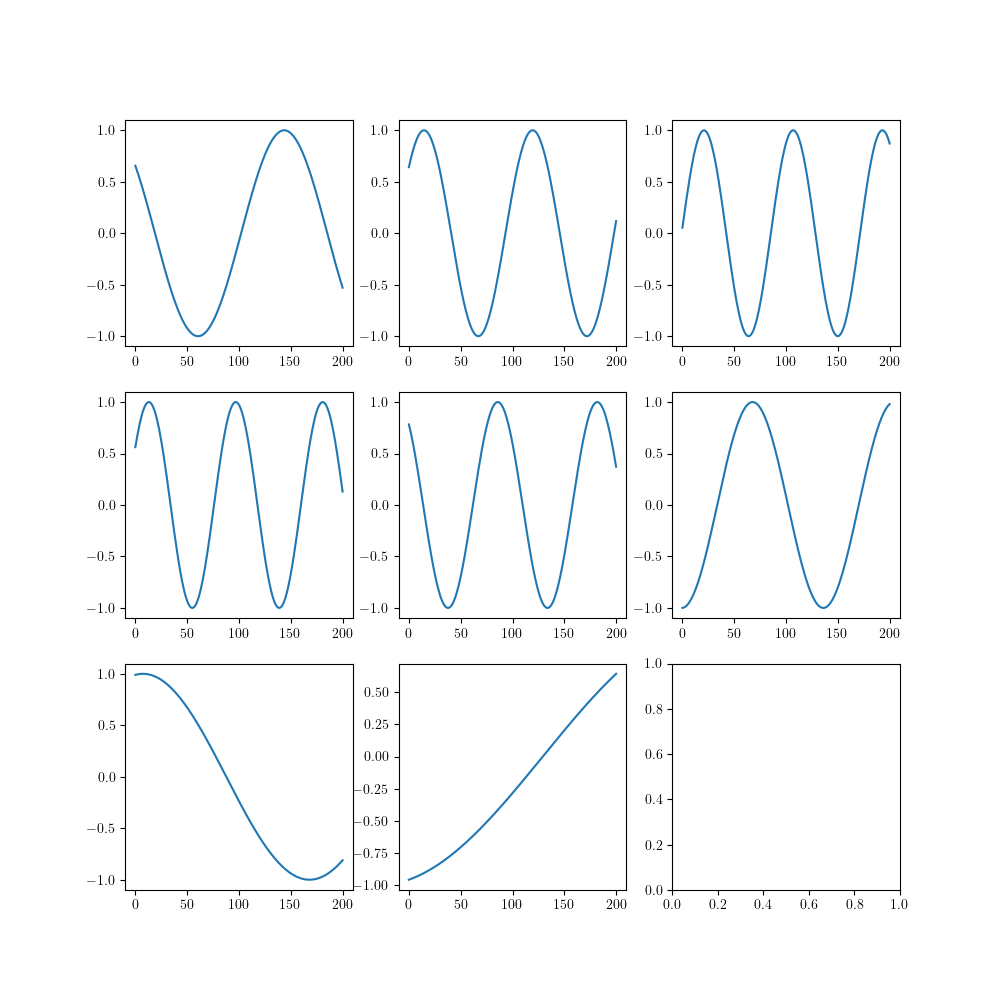

In [104]:
F, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.reshape(-1)[:-1]):
    ax.plot(raw_tape[0, :, i])

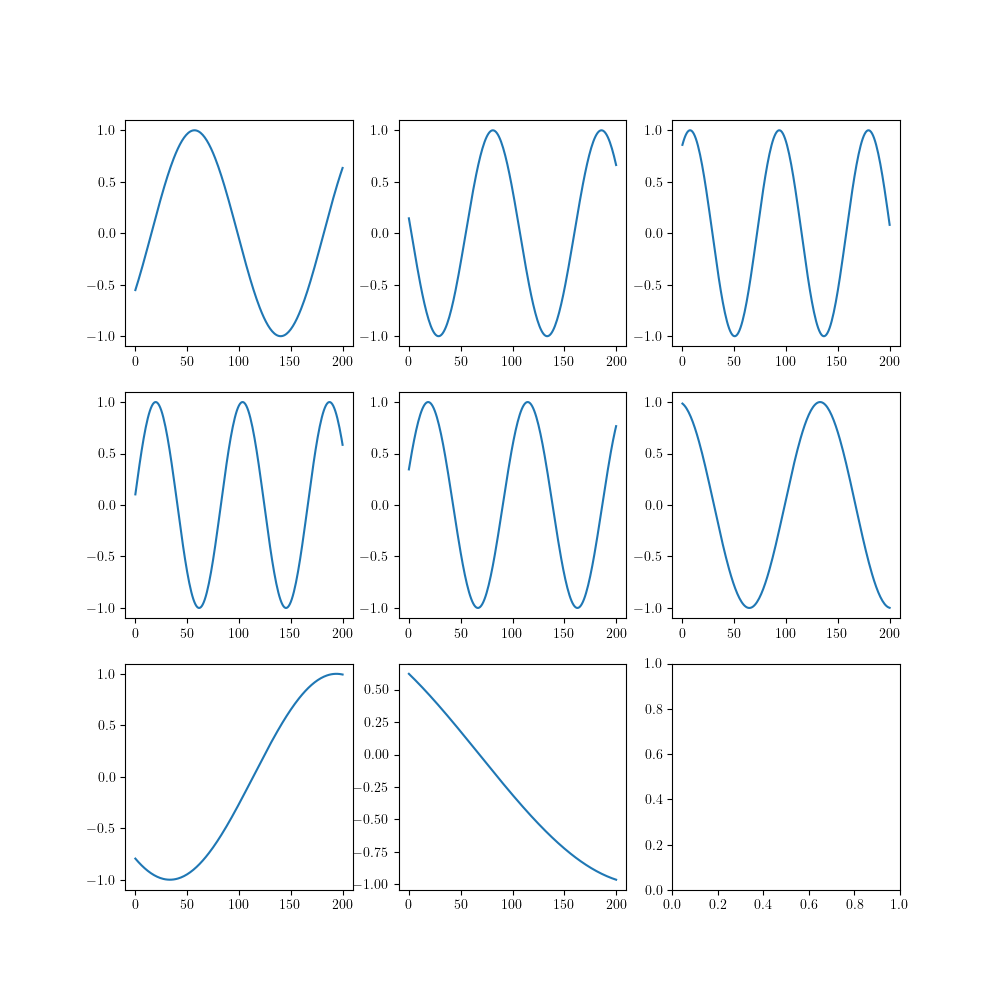

In [105]:
F, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.reshape(-1)[:-1]):
    ax.plot(raw_tape[50, :, i])